In [1]:
%load_ext autoreload
%autoreload 2

In [96]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from neurodsp.plts.time_series import plot_time_series
from scipy.stats import median_abs_deviation

from ecephys.graham import channel_groups, paths
from ecephys.utils.utils import load_df_h5
from ecephys.plot import plot_hypnogram_overlay
from ecephys.scoring import load_visbrain_hypnogram, make_empty_hypnogram
from ecephys.sglx_utils import load_timeseries
from ecephys.signal.ripples import get_epoched_ripple_density
from ecephys.signal.timefrequency import get_bandpower, parallel_spectrogram_welch

In [133]:
def discard_outliers(x):
    mad = median_abs_deviation(x)
    threshold = np.median(x) + 6 * mad
    return x[x <= threshold]

In [76]:
from dataclasses import dataclass

@dataclass
class Condition:
    hypnogram: pd.DataFrame
    epochs: pd.DataFrame
    swa: np.ndarray
    spg_times: np.ndarray

In [77]:
def get_data_to_plot(subject, condition):
    
    # Load data
    ripple_path = Path(paths.ripples[condition][subject])
    with pd.HDFStore(ripple_path) as store:
        ripples, metadata = load_df_h5(store)

    chans = channel_groups.superficial_ctx[subject]
    bin_path = Path(paths.lfp_bin[condition][subject])
    (times, sig, fs) = load_timeseries(bin_path, chans, start_time=None, end_time=None)
    
    try:
        hypnogram_path = Path(paths.hypnograms[condition][subject])
    except KeyError:
        hypnogram = make_empty_hypnogram(np.max(times))
    else:
        hypnogram = load_visbrain_hypnogram(hypnogram_path)
    
    # Compute quantities 
    epochs = get_epoched_ripple_density(ripples, np.min(hypnogram.start_time), np.max(hypnogram.end_time), epoch_length=10)

    freqs, spg_times, spg = parallel_spectrogram_welch(sig, fs, nperseg = 2 ** 15)
    spg = np.median(spg, axis=-1)

    swa = get_bandpower(freqs, spg_times, spg, f_range=(0.5, 4))
    
    # Return
    return Condition(hypnogram=hypnogram, epochs=epochs, swa=swa, spg_times=spg_times) 

In [129]:
def plot_data(results):
    
    min_swa = np.min([np.min(discard_outliers(results[condition].swa)) for condition in results.keys()])
    max_swa = np.max([np.max(discard_outliers(results[condition].swa)) for condition in results.keys()])
    
    max_ripple_density = np.max([np.max(results[condition].epochs.ripple_density.to_numpy()) for condition in results.keys()])
    
    for condition in results.keys():
        spg_times = results[condition].spg_times
        swa = results[condition].swa
        epochs = results[condition].epochs
        hypnogram = results[condition].hypnogram
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 6))
        fig.suptitle(condition, fontsize=30, ha='left', x=0.1, y=.95)
        plot_time_series(spg_times, swa, ax=ax1, title="SWA (0.5 - 4 Hz)", ylabel="PSD (uV$^2$/Hz)", ylim=[min_swa, max_swa])
        plot_hypnogram_overlay(hypnogram, ax=ax1)
        plot_time_series(epochs.center_time.to_numpy(), epochs.ripple_density.to_numpy(), ax=ax2, title="Ripple density (10s epochs)", ylabel="Hz", ylim=[0, max_ripple_density])
        plot_hypnogram_overlay(hypnogram, ax=ax2)
        ax2.set_xlim(ax1.get_xlim())

# Segundo

In [70]:
subject = "Segundo"
Segundo = dict()

In [ ]:
Segundo["Baseline"] = get_data_to_plot(subject, "BL")

In [9]:
Segundo["Pre-Recovery"] = get_data_to_plot(subject, "pre-SR")

nChan: 385, nFileSamp: 18000001


In [10]:
Segundo["Recovery"] = get_data_to_plot(subject, "SR")

nChan: 385, nFileSamp: 18000001


In [ ]:
# Segundo's recovery sleep starts at 1:42:28 = 6148 seconds into t22

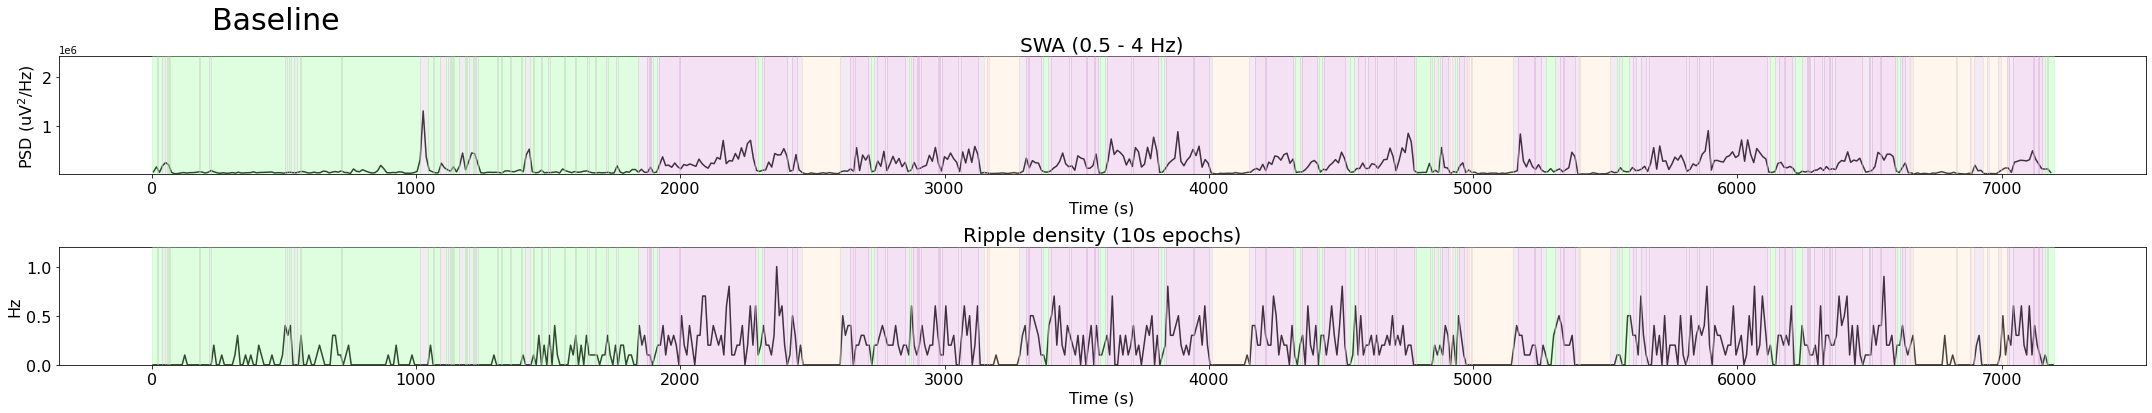

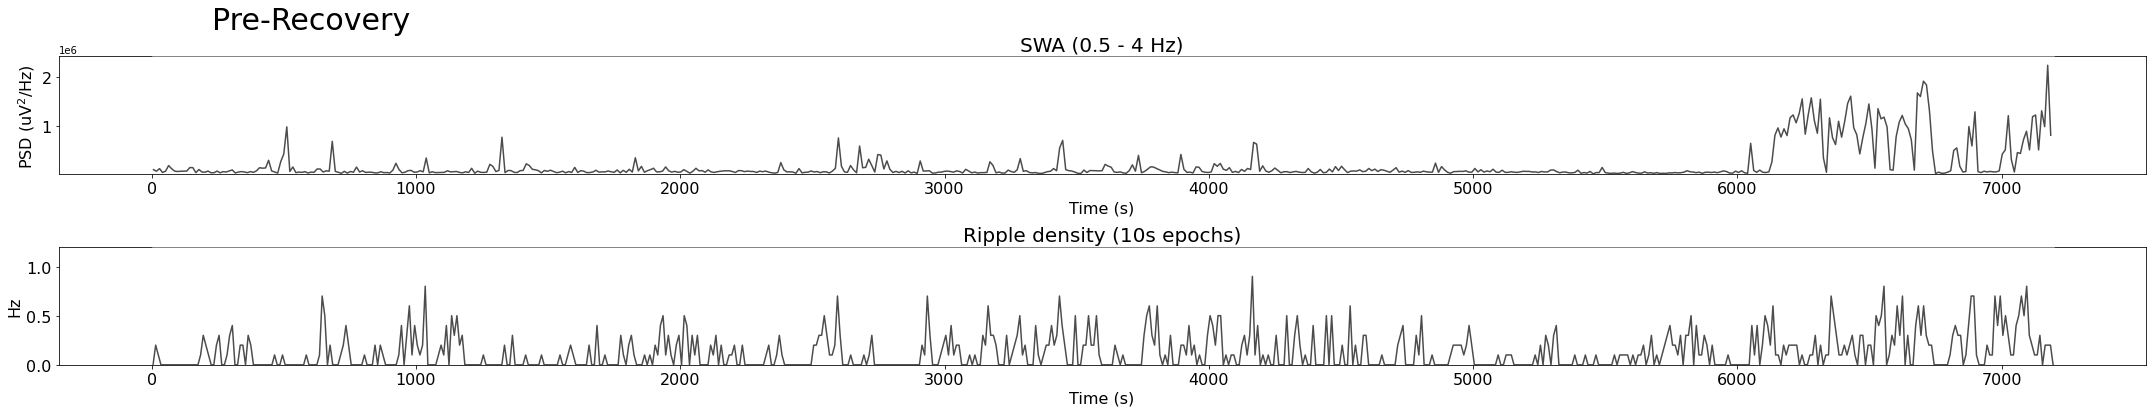

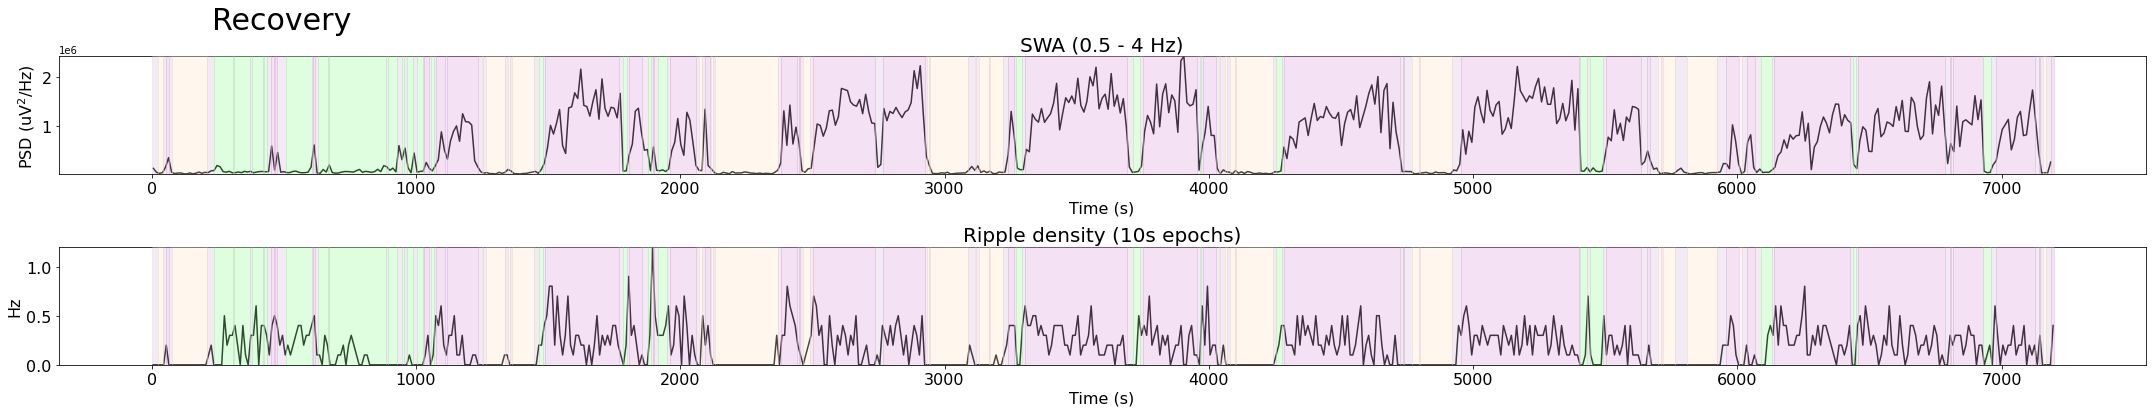

In [134]:
plot_data({'Baseline': Segundo["Baseline"], 'Pre-Recovery': Segundo["Pre-Recovery"], 'Recovery': Segundo["Recovery"]})

# Valentino

In [80]:
subject = "Valentino"
Valentino = dict()

In [81]:
Valentino["Baseline"] = get_data_to_plot(subject, "BL")

nChan: 385, nFileSamp: 18000000


In [82]:
Valentino["Pre-Recovery"] = get_data_to_plot(subject, "pre-SR")

nChan: 385, nFileSamp: 18000000


In [83]:
Valentino["Recovery"] = get_data_to_plot(subject, "SR")

nChan: 385, nFileSamp: 18000000


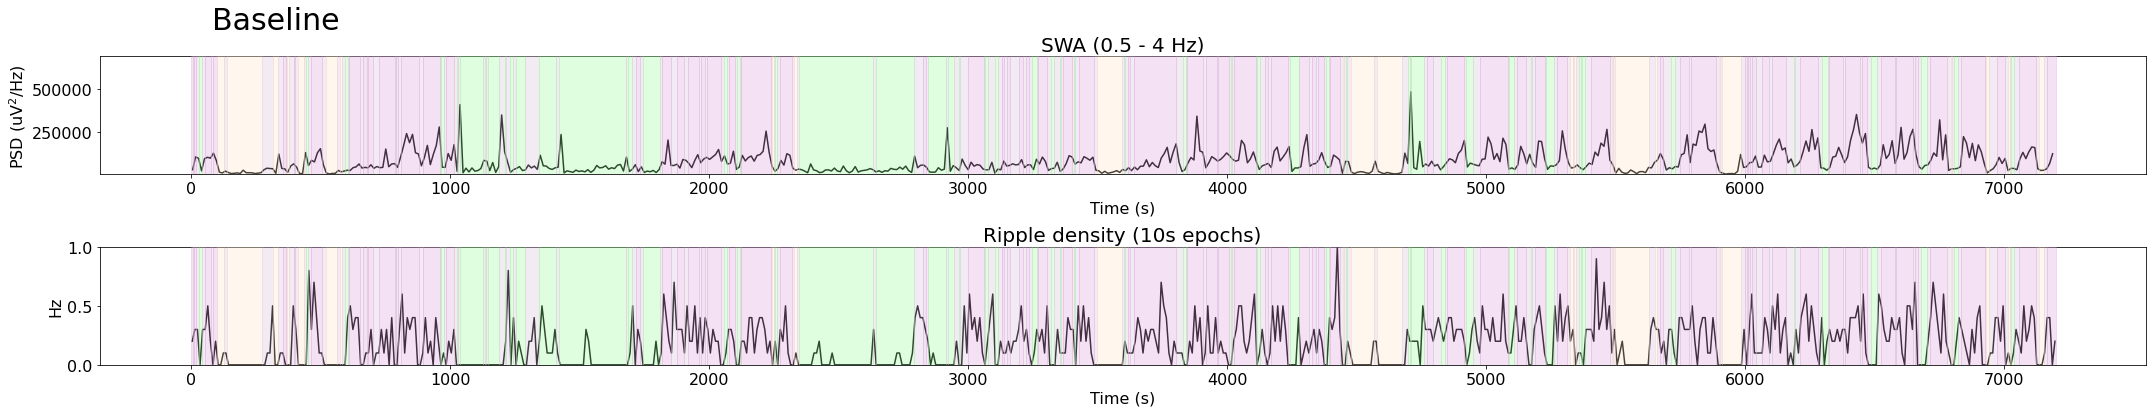

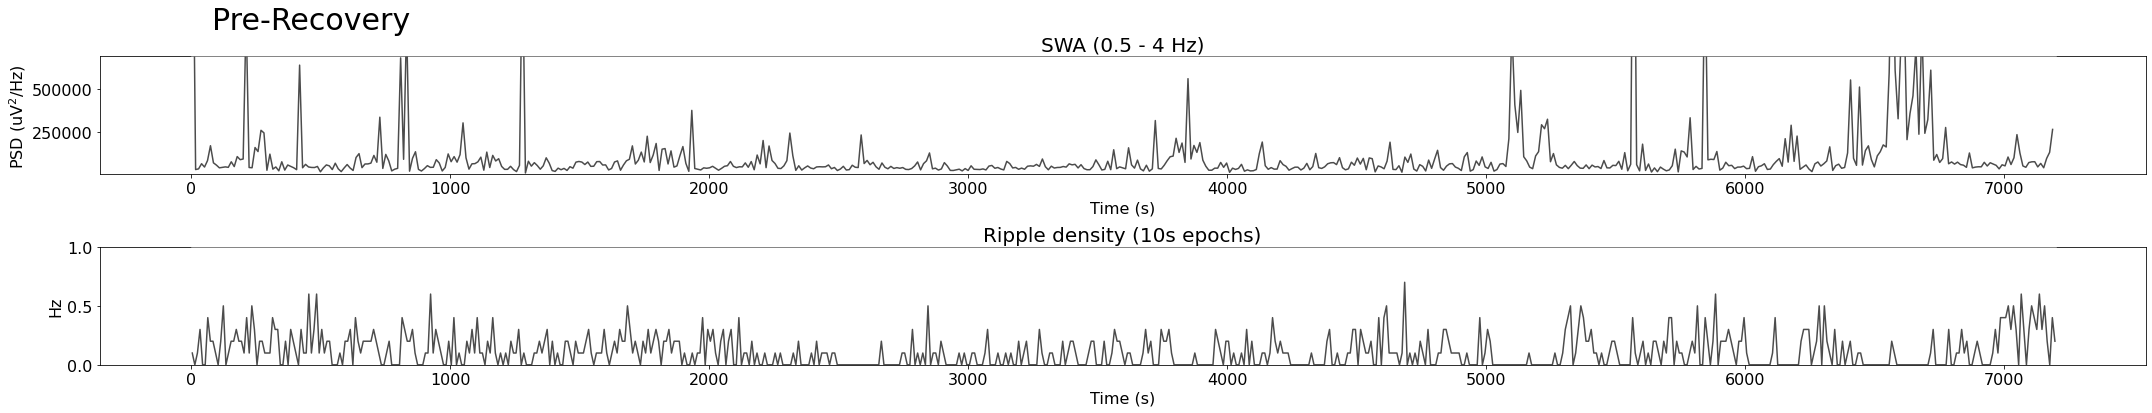

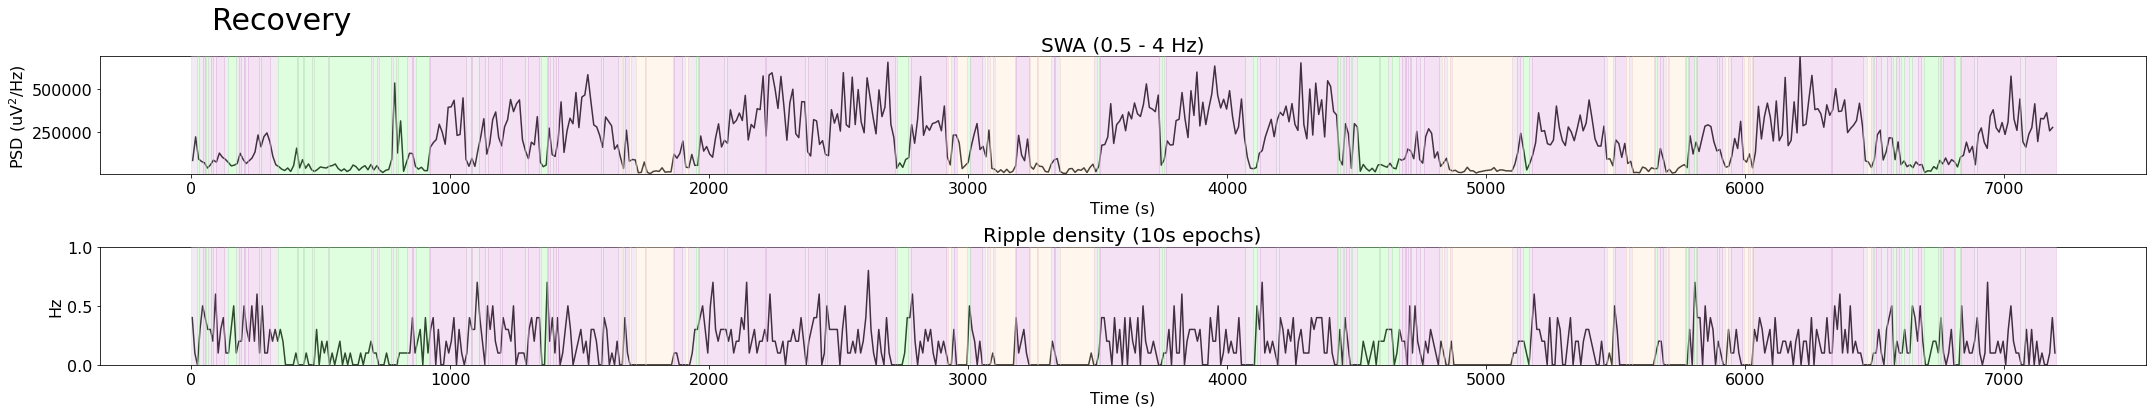

In [135]:
plot_data({'Baseline': Valentino["Baseline"], 'Pre-Recovery': Valentino["Pre-Recovery"], 'Recovery': Valentino["Recovery"]})

# Doppio

In [85]:
subject = "Doppio"
Doppio = dict()

In [86]:
Doppio["Baseline"] = get_data_to_plot(subject, "BL")

nChan: 385, nFileSamp: 18000019


In [87]:
Doppio["Pre-Recovery"] = get_data_to_plot(subject, "pre-SR")

nChan: 385, nFileSamp: 18000019


In [88]:
Doppio["Recovery"] = get_data_to_plot(subject, "SR")

nChan: 385, nFileSamp: 18000019


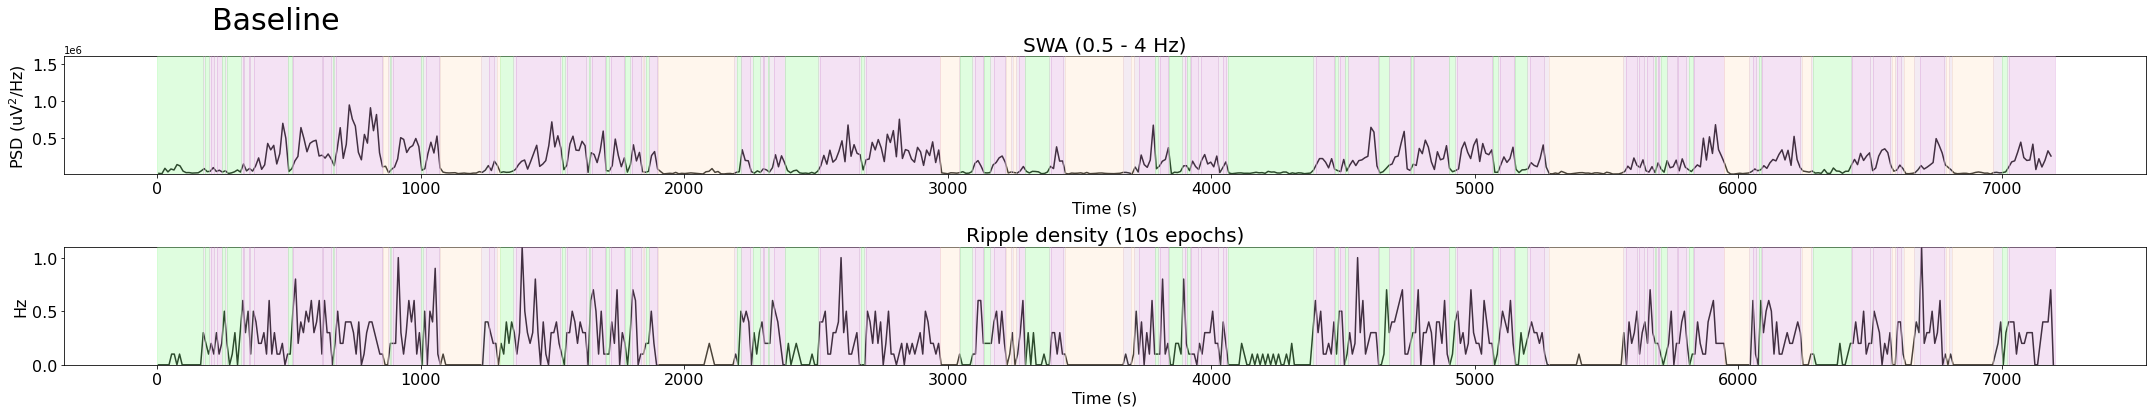

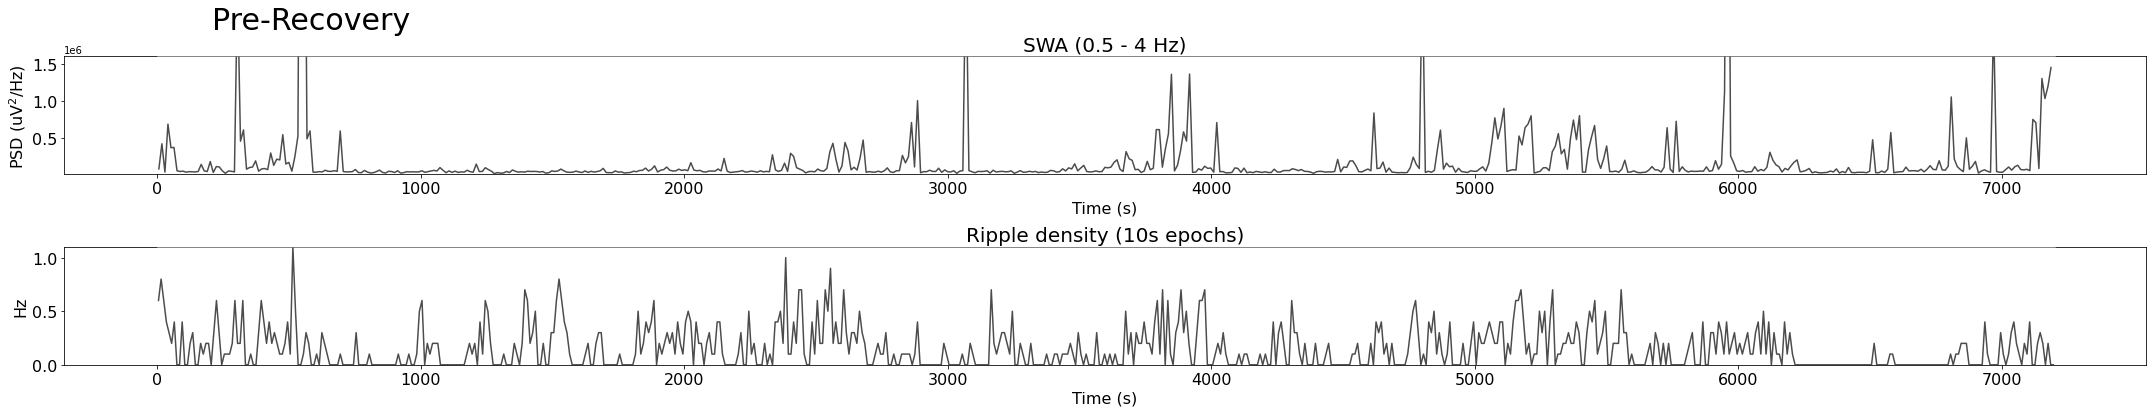

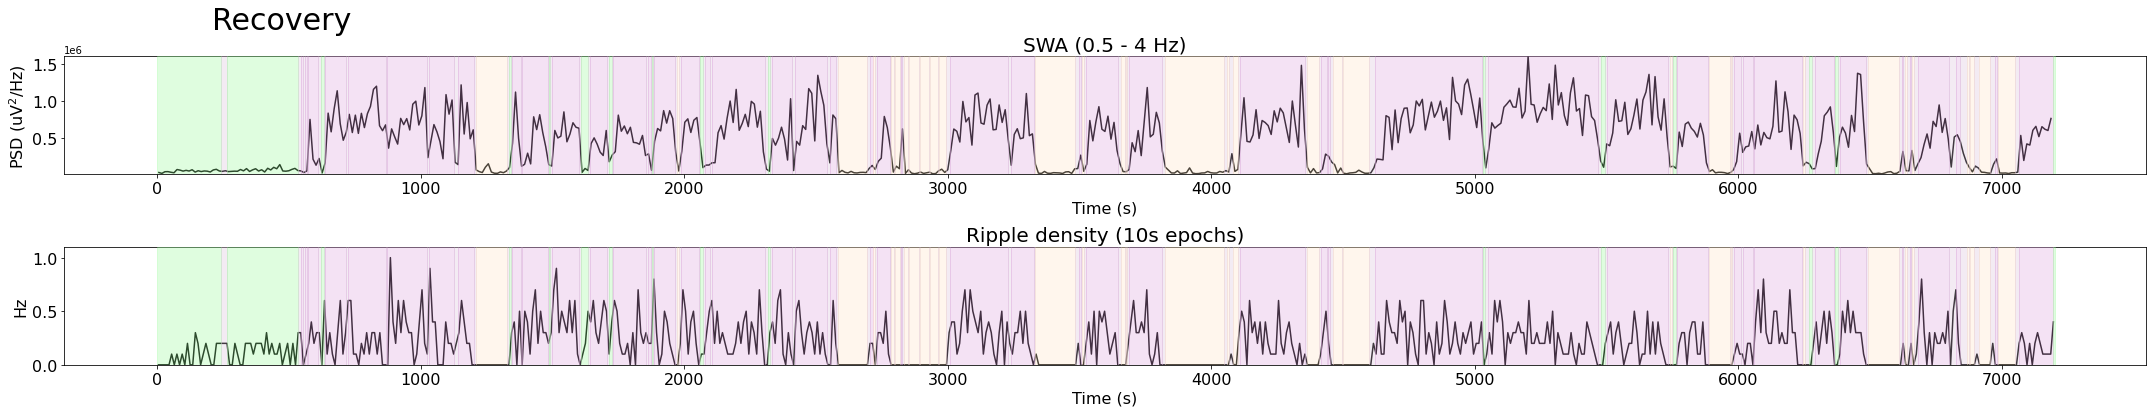

In [136]:
plot_data({'Baseline': Doppio["Baseline"], 'Pre-Recovery': Doppio["Pre-Recovery"], 'Recovery': Doppio["Recovery"]})

# Alessandro

In [137]:
subject = "Alessandro"
Alessandro = dict()

In [138]:
Alessandro["Baseline"] = get_data_to_plot(subject, "BL")

nChan: 385, nFileSamp: 9000052


In [139]:
Alessandro["Recovery"] = get_data_to_plot(subject, "SR")

nChan: 385, nFileSamp: 9000052


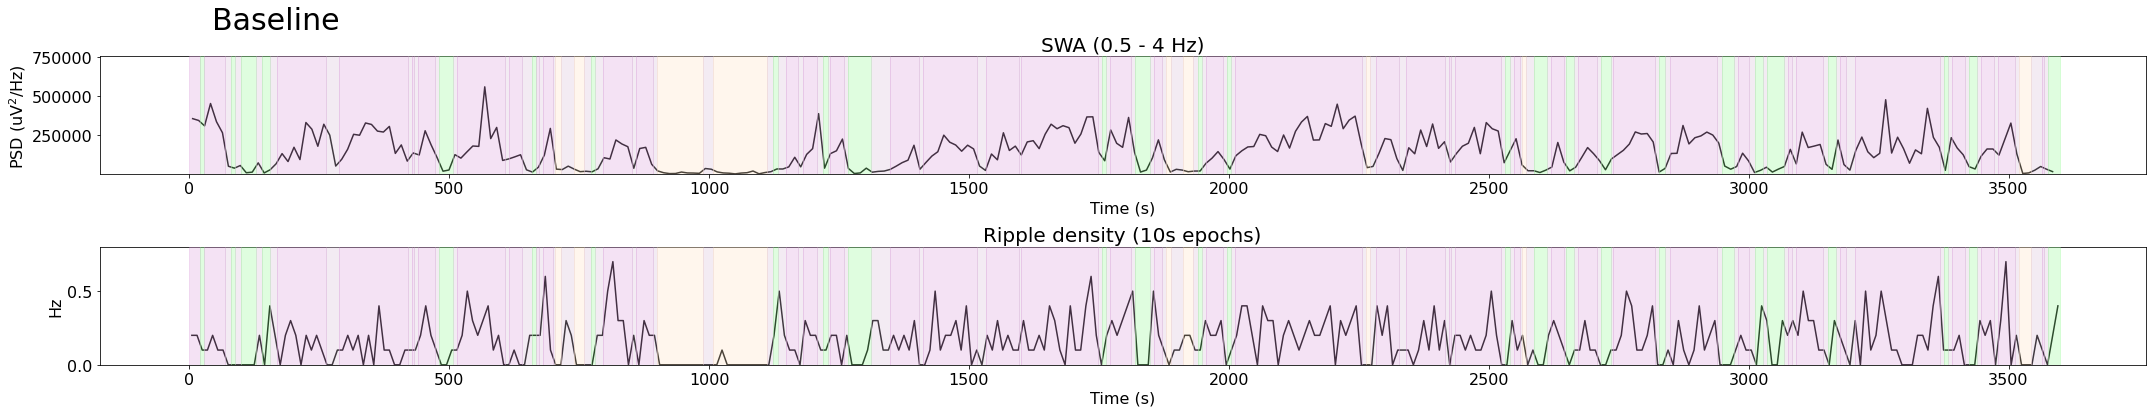

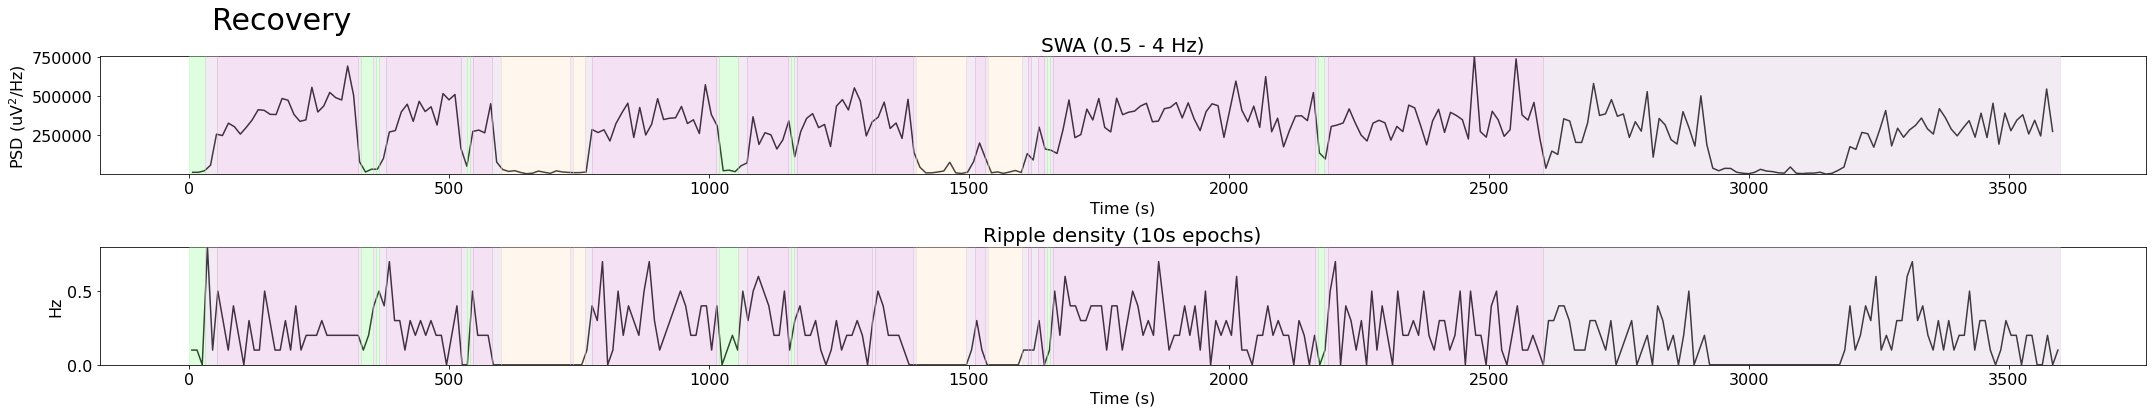

In [140]:
plot_data({'Baseline': Alessandro["Baseline"], 'Recovery': Alessandro["Recovery"]})

# Eugene

In [141]:
subject = "Eugene"
Eugene = dict()

In [142]:
Eugene["Baseline"] = get_data_to_plot(subject, "BL")

nChan: 385, nFileSamp: 9000025


In [143]:
Eugene["Recovery"] = get_data_to_plot(subject, "SR")

nChan: 385, nFileSamp: 9000026


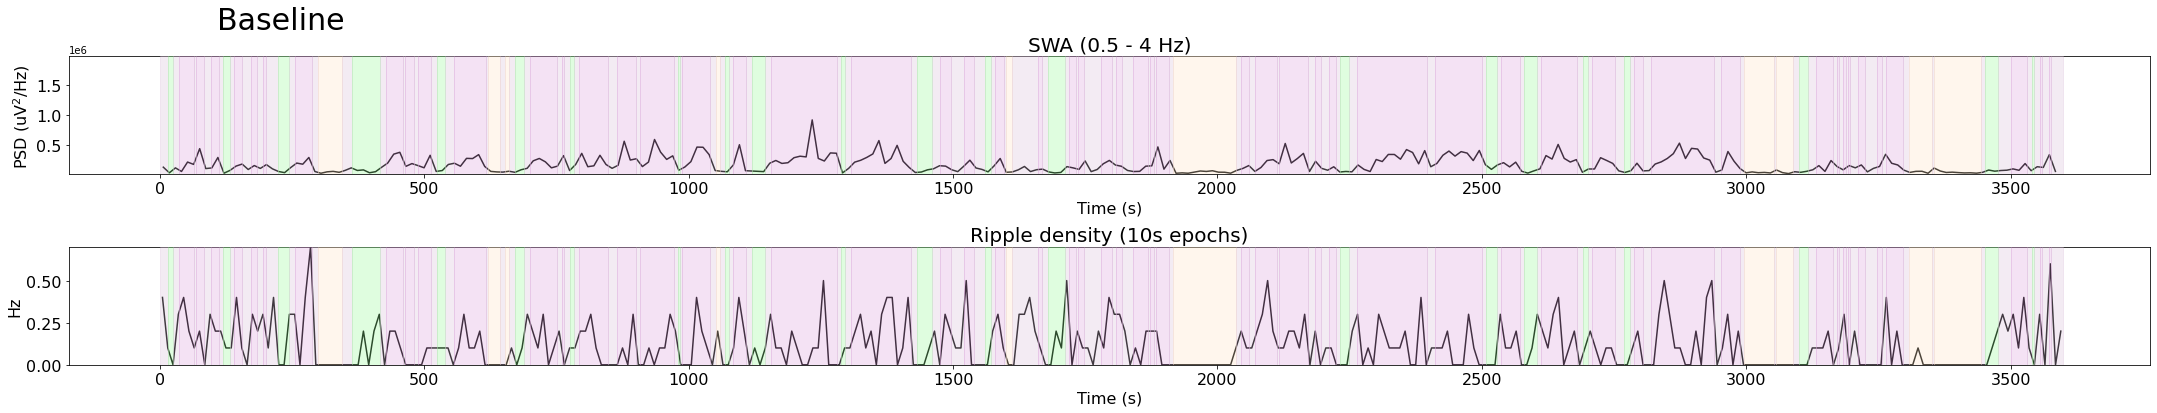

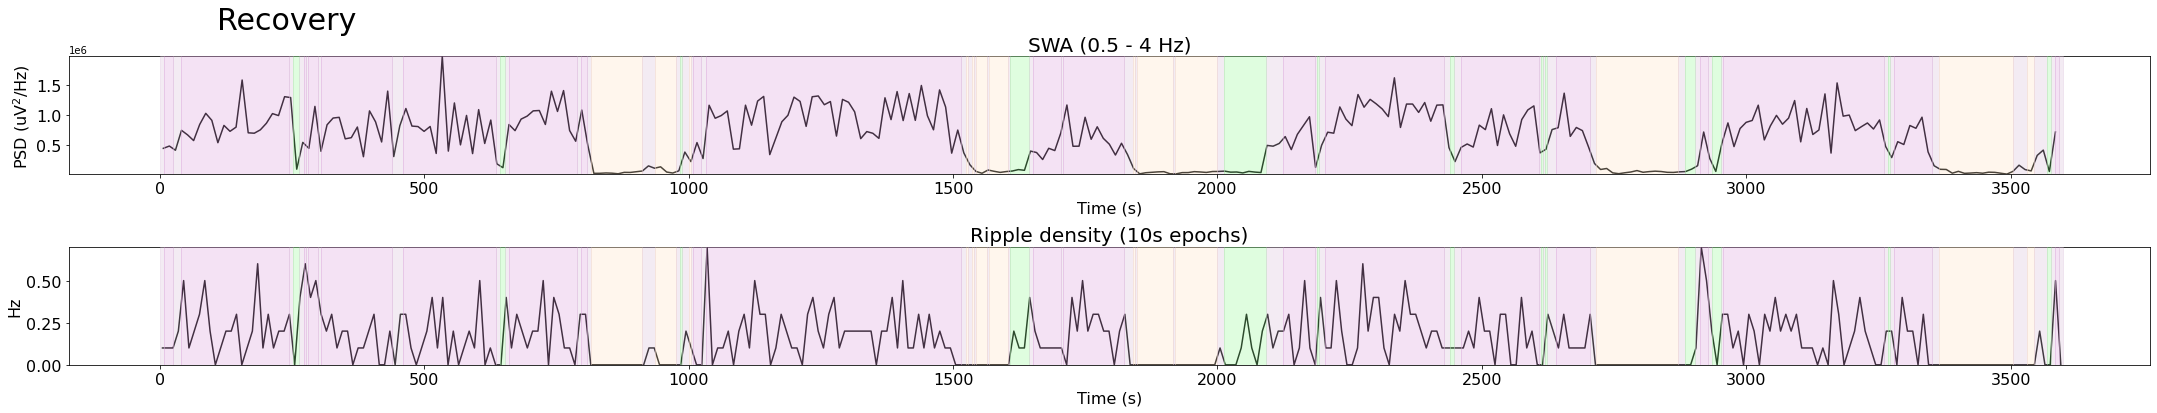

In [144]:
plot_data({'Baseline': Eugene["Baseline"], 'Recovery': Eugene["Recovery"]})